# Выбор локации для скважины

Работаета в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

# Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).<br>
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.<br>
Бюджет на разработку скважин в регионе — 10 млрд рублей.<br>
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.<br>
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.<br>

# План выполнения проекта.

1. Загрузка и подготовка данных: ознакомимся с данными и Проведем необходимую предобработку.
2. Исследовательский анализ данных. Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.
3. Корреляционный анализ. Изучим взаимосвязь признаков.
4. Обучение моделей. Будем использовать несколько моделей для каждого региона. Вывудем средний запас предсказанного сырья и RMSE модели.
5. Подготовка к рачету прибыли. Все ключевые значения для расчётов сохраним в отдельных переменных. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 
6. Функция для расчета прибыли и рисков. Выберим скважины с максимальными значениями предсказаний.  Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям. Рассчитаем прибыль для полученного объёма сырья.
7. Расчет прибыли и рисков для каждого региона. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.
8. Общий вывод.

In [88]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [89]:
!pip install phik -q

In [90]:
!pip install scikit-learn==1.3.2 -q

In [91]:
# импортируем все необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn.inspection import permutation_importance
import phik
from numpy import quantile
from sklearn.dummy import DummyRegressor
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import (mean_squared_error, mean_absolute_error, confusion_matrix,
                             accuracy_score, precision_score, recall_score, r2_score, roc_auc_score, make_scorer)
RANDOM_STATE = 42

## Загрузка и подготовка данных

###  Загрузка данных.

Загрузим и сохраним таблицу первого региона.

In [92]:
geo_data0 = pd.read_csv('/####.csv')
geo_data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Взглянем на общую информацию о таблице.

In [93]:
geo_data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Видим, что формат данных соответствует истеному.

Загрузим и сохраним таблицу второго региона.

In [94]:
geo_data1 = pd.read_csv('/####.csv')
geo_data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Взглянем на общую информацию о таблице.

In [95]:
geo_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Видим, что формат данных соответствует истеному.

Загрузим и сохраним таблицу третьего региона.

In [96]:
geo_data2 = pd.read_csv('/####.csv')
geo_data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Взглянем на общую информацию о таблице.

In [97]:
geo_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Видим, что формат данных соответствует истеному.

### Предобработка.

Проведем предобработку - проверим наличие пропусков и дубликатов во всех таблицах.

In [98]:
geo_data0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [99]:
geo_data0.duplicated().sum()

0

In [100]:
geo_data0.drop(['id','product'],axis=1).duplicated().sum()

0

In [101]:
geo_data1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [102]:
geo_data1.duplicated().sum()

0

In [103]:
geo_data1.drop(['id','product'],axis=1).duplicated().sum()

0

In [104]:
geo_data2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [105]:
geo_data2.duplicated().sum()

0

In [106]:
geo_data2.drop(['id','product'],axis=1).duplicated().sum()

0

### Вывод по загрузке и подготовке данных. 
1. Все три таблицы сохранили в переменные.
2. Формат данных соотвествует истеному.
3. Пропусков и дубликатов нет.

## Исследовательский анализ.

Сейчас проведем исследовательский анализ - посмотрим на расспределение целевого и входных признаков а так же на остальную статистику. 

### Анализ geo_data0.

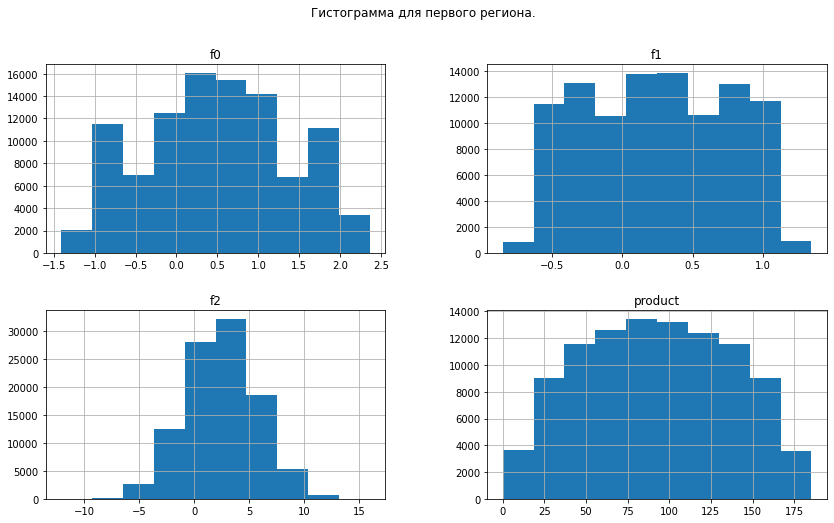

In [107]:
geo_data0.hist(figsize=(14, 8))
plt.suptitle('Гистограмма для первого региона.')
plt.show()

Расспределение данных в первом регионе:
1. Расспределение "product" близко к нормальному.
2. "f2" стремится к нормальному расспределению.
3. "fo" и "f1" не имеют нормального расспределения.

Статистика для первого региона.

In [108]:
geo_data0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [109]:
geo_data0['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

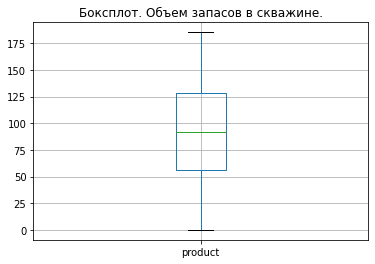

In [110]:
geo_data0.boxplot(column='product')
plt.title('Боксплот. Объем запасов в скважине.')
plt.show()

Значения "product" , в основном,  лежат в диапозоне от 56.5 до 128.6 тыс.барелей. Боксплот показывает отсутствие выбросов.

In [111]:
geo_data0['f0'].describe()

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

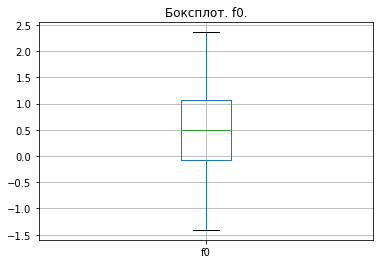

In [112]:
geo_data0.boxplot(column='f0')
plt.title('Боксплот. f0.')
plt.show()

Большая часть значений "f0" от -0.07 до 1.01. Выбросов нет.

In [113]:
geo_data0['f1'].describe()

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

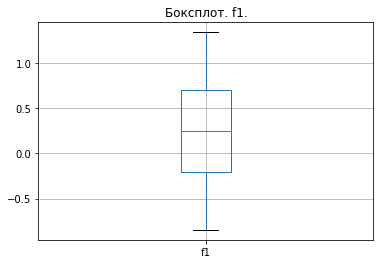

In [114]:
geo_data0.boxplot(column='f1')
plt.title('Боксплот. f1.')
plt.show()

В основном, "f1" в диапозоне от -0.2 до 0.7. Выбросы отсутствуют.

In [115]:
geo_data0['f2'].describe()

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

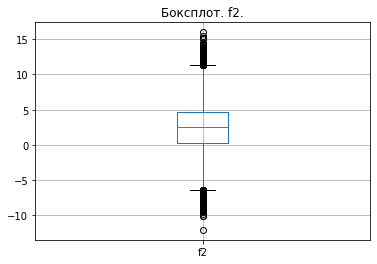

In [116]:
geo_data0.boxplot(column='f2')
plt.title('Боксплот. f2.')
plt.show()

Значения "f2" по большей чатси, от 0.288 до 4.7. На боксплоте видим выбросы в верхней и нежний частях. Нам не известно что именно из себя представляют входные признаки, но т.к. нам нужно будет использовать модель линейной регрессии, выбросы придется убрать, они плохо повлияют на обучение модели.

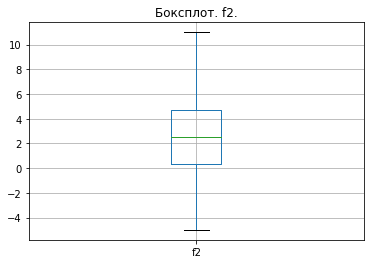

In [117]:
geo_data0[(geo_data0['f2']<11)&(geo_data0['f2']> -5)].boxplot(column='f2')
plt.title('Боксплот. f2.')
plt.show()

In [118]:
geo_data0 = geo_data0[(geo_data0['f2']<11)&(geo_data0['f2']> -5)]
geo_data0.shape

(98647, 5)

Удалили 1353 скважины.

#### Выводы по анализу первого региона.<br>
1. Расспределение данных в первом регионе:<br>
1) Расспределение "product" близко к нормальному.<br>
2) "f2" стремится к нормальному расспределению.<br>
3) "fo" и "f1" не имеют нормального расспределения.<br>
2. Значения "product" , в основном, лежат в диапозоне от 56.5 до 128.6 тыс.барелей. Боксплот показывает отсутствие выбросов.<br>
3. Большая часть значений "f0" от -0.07 до 1.01. Выбросов нет.<br>
4. В основном, "f1" в диапозоне от -0.2 до 0.7. Выбросы отсутствуют.<br>
5. Значения "f2" по большей чатси, от 0.288 до 4.7. На боксплоте видим выбросы в верхней и нежний частях. Нам не известно что именно из себя представляют входные признаки, но т.к. нам нужно будет использовать модель линейной регрессии, выбросы придется убрать, они плохо повлияют на обучение модели. Удалили 1353 скважины.<br>

### Анализ geo_data1.

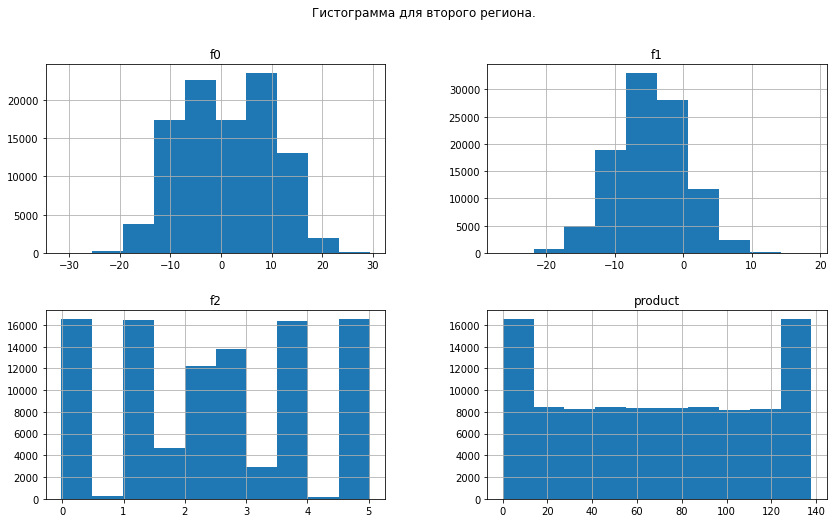

In [119]:
geo_data1.hist(figsize=(14, 8))
plt.suptitle('Гистограмма для второго региона.')
plt.show()

Расспределение данных во втором регионе. Только у "f1" расспределение близко к нормальному, у остальных данных нет.

Статистика для второго региона.

In [120]:
geo_data1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


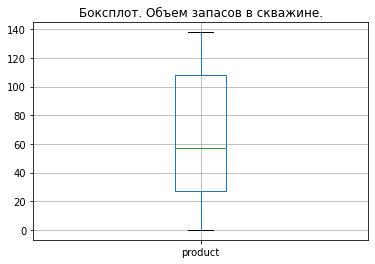

In [121]:
geo_data1.boxplot(column='product')
plt.title('Боксплот. Объем запасов в скважине.')
plt.show()

Значения "product" , в основном, лежат в диапозоне от 26.95 до 107.8 тыс.барелей. Боксплот показывает отсутствие выбросов.

In [122]:
geo_data1['f0'].describe()

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64

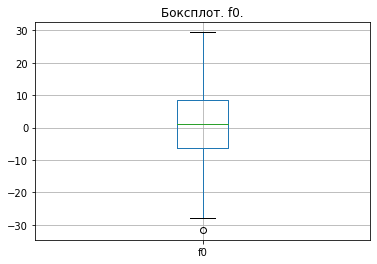

In [123]:
geo_data1.boxplot(column='f0')
plt.title('Боксплот. f0.')
plt.show()

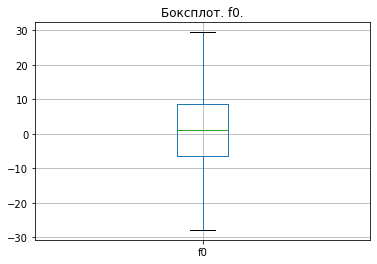

In [124]:
geo_data1[geo_data1['f0']>-29].boxplot(column='f0')
plt.title('Боксплот. f0.')
plt.show()

Большая часть значений "f0" от -6.3 до 8.6. На боксплоте обнаружили выброс. Уберем его.

In [125]:
geo_data1 = geo_data1[geo_data1['f0']>-29]

In [126]:
geo_data1['f1'].describe()

count    99999.000000
mean        -4.796641
std          5.119860
min        -26.358598
25%         -8.268043
50%         -4.813297
75%         -1.332845
max         18.734063
Name: f1, dtype: float64

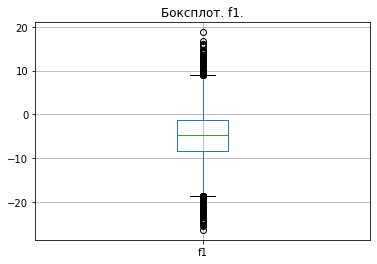

In [127]:
geo_data1.boxplot(column='f1')
plt.title('Боксплот. f1.')
plt.show()

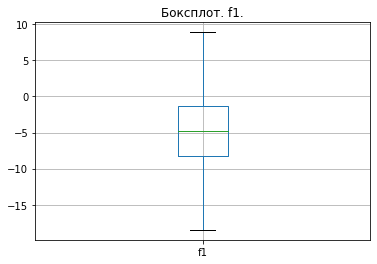

In [128]:
geo_data1[(geo_data1['f1']> -18.5)&(geo_data1['f1']<8.9)].boxplot(column='f1')
plt.title('Боксплот. f1.')
plt.show()

В основном, "f1" в диапозоне от -8.26 до -1.33. Так же на боксплоте обнаружили выбросы. Уберем их.

In [129]:
geo_data1 = geo_data1[(geo_data1['f1']> -18.5)&(geo_data1['f1']<8.9)]

In [130]:
geo_data1['f2'].describe()

count    99290.000000
mean         2.493867
std          1.703253
min         -0.018144
25%          1.000016
50%          2.011339
75%          3.999892
max          5.019721
Name: f2, dtype: float64

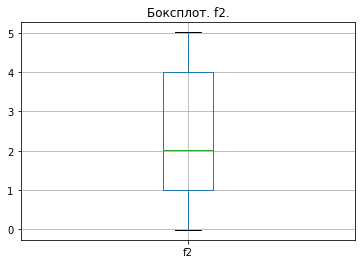

In [131]:
geo_data1.boxplot(column='f2')
plt.title('Боксплот. f2.')
plt.show()

Значения "f2" по большей чатси, от 1 до 3.99. Выбросов нет.

In [132]:
geo_data1.shape

(99290, 5)

Убрали 710 скважин.

#### Вывод по анализу второго региона.
1. Расспределение данных во втором регионе. Только у "f1" расспределение близко к нормальному, у остальных данных нет.
2. Значения "product" , в основном, лежат в диапозоне от 26.95 до 107.8 тыс.барелей. Боксплот показывает отсутствие выбросов.
3. Большая часть значений "f0" от -6.3 до 8.6. На боксплоте обнаружили выброс. Убрали его.
4. В основном, "f1" в диапозоне от -8.26 до -1.33. Так же на боксплоте обнаружили выбросы. Избавились от них.
5. Значения "f2" по большей чатси, от 1 до 3.99. Выбросов нет.
6. Всего убрали 710 скважин.

### Анализ geo_data2.

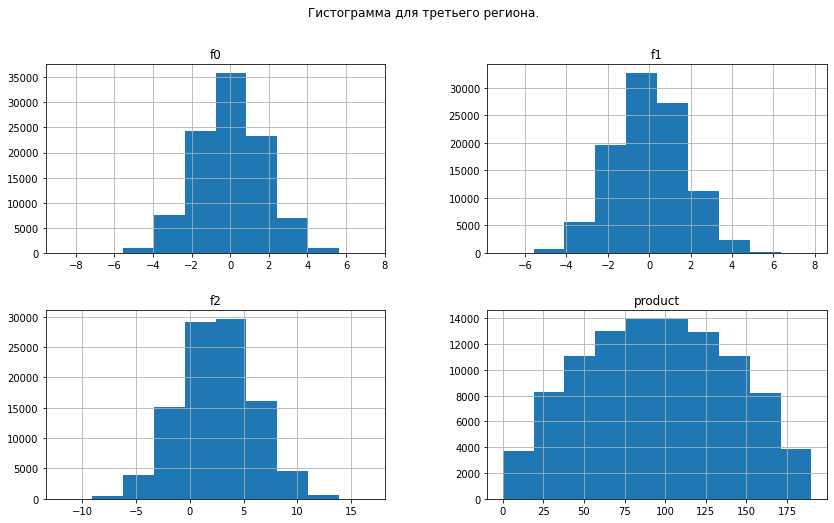

In [133]:
geo_data2.hist(figsize=(14, 8))
plt.suptitle('Гистограмма для третьего региона.')
plt.show()

Расспределение "product" в третьем регионе похоже на нормальное, остальные признаки так же стремятся к нормальному расспределению.

Статистика третьего региона.

In [134]:
geo_data2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


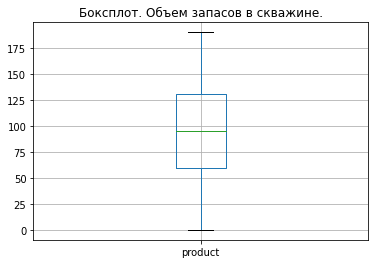

In [135]:
geo_data2.boxplot(column='product')
plt.title('Боксплот. Объем запасов в скважине.')
plt.show()

Значения "product" , в основном, лежат в диапозоне от 59.45 до 130.6 тыс.барелей. Боксплот показывает отсутствие выбросов.

In [136]:
geo_data2['f0'].describe()

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

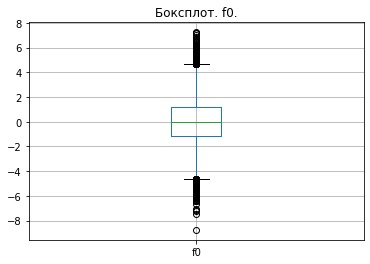

In [137]:
geo_data2.boxplot(column='f0')
plt.title('Боксплот. f0.')
plt.show()

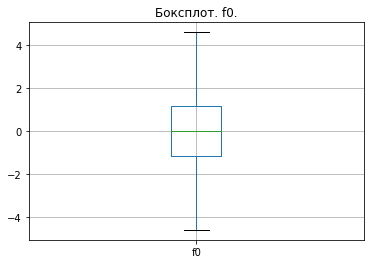

In [138]:
geo_data2[(geo_data2['f0']> -4.6)&(geo_data2['f0']<4.6)].boxplot(column='f0')
plt.title('Боксплот. f0.')
plt.show()

Большая часть значений "f0" от -1.15 до 1.14. На боксплоте обнаружили выбросы. Уберем их.

In [139]:
geo_data2 = geo_data2[(geo_data2['f0']> -4.6)&(geo_data2['f0']<4.6)]

In [140]:
geo_data2['f1'].describe()

count    99220.000000
mean        -0.001928
std          1.730579
min         -7.084020
25%         -1.174506
50%         -0.009312
75%          1.163504
max          7.844801
Name: f1, dtype: float64

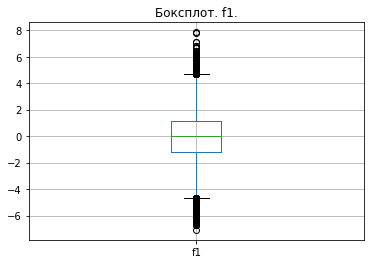

In [141]:
geo_data2.boxplot(column='f1')
plt.title('Боксплот. f1.')
plt.show()

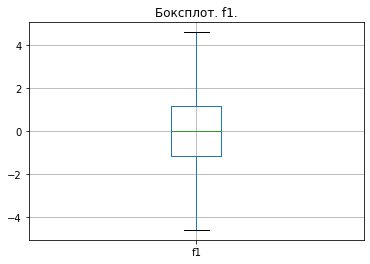

In [142]:
geo_data2[(geo_data2['f1']> -4.6)&(geo_data2['f1']<4.6)].boxplot(column='f1')
plt.title('Боксплот. f1.')
plt.show()

В основном, "f1" в диапозоне от -7.06 до 1.16. Так же на боксплоте обнаружили выбросы. Уберем их.

In [143]:
geo_data2 = geo_data2[(geo_data2['f1']> -4.6)&(geo_data2['f1']<4.6)]

In [144]:
geo_data2['f2'].describe()

count    98453.000000
mean         2.492562
std          3.474067
min        -11.970335
25%          0.127908
50%          2.481906
75%          4.856280
max         16.739402
Name: f2, dtype: float64

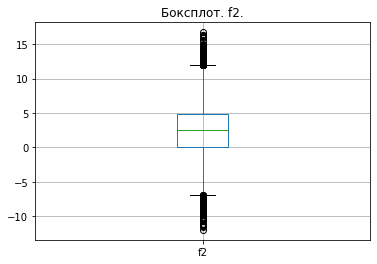

In [145]:
geo_data2.boxplot(column='f2')
plt.title('Боксплот. f2.')
plt.show()

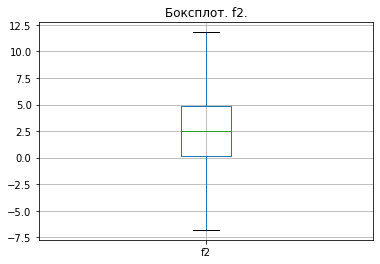

In [146]:
geo_data2[(geo_data2['f2']> -6.8)&(geo_data2['f2']<11.8)].boxplot(column='f2')
plt.title('Боксплот. f2.')
plt.show()

Значения "f2" по большей чатси, от 0.13 до 4.85. Так же на боксплоте обнаружили выбросы. Уберем их.

In [147]:
geo_data2.shape

(98453, 5)

Удалили 1547 скважин.

#### Вывод по анализу третьего региона.
1. Расспределение "product" в третьем регионе похоже на нормальное, остальные признаки так же стремятся к нормальному расспределению.
2. Значения "product" , в основном, лежат в диапозоне от 59.45 до 130.6 тыс.барелей. Боксплот показывает отсутствие выбросов.
3. Большая часть значений "f0" от -1.15 до 1.14. На боксплоте обнаружили выбросы. Убрали их.
4. В основном, "f1" в диапозоне от -7.06 до 1.16. Так же на боксплоте обнаружили выбросы. Избавились от них.
5. Значения "f2" по большей чатси, от 0.13 до 4.85. Так же на боксплоте обнаружили выбросы. Убрали их.
6. Удалили 1547 скважин.

### Вывод по исследовательскому анализу.
1. В таблицах всех регионов были обнаружены выбросы, пришлось их удалить. Они плохо повлияют на обучение модели линейной регрессии.
2. Даныые отличаются от региона к региону, поэтому создадим отдельные модели для каждого.

## Корреляционный анализ.

Сейчас проведем корреляционыый анализ и посмотрим как входные признаки взаимодействует с целевым.

### Корреляционный анализ geo_data0.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


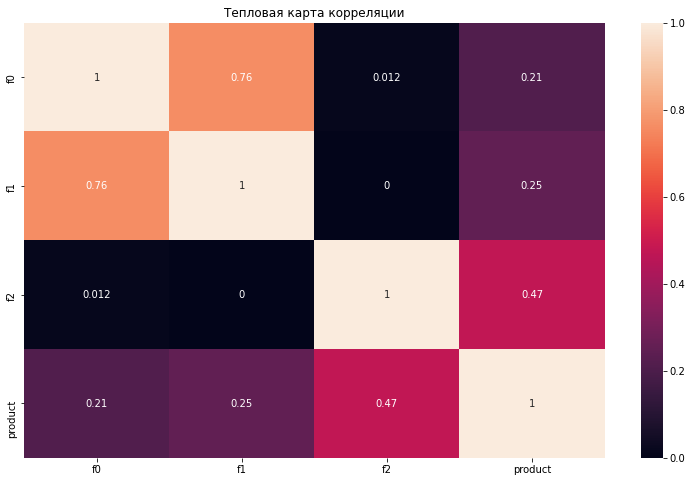

In [148]:
plt.figure(figsize=(13, 8))
sns.heatmap(geo_data0.drop('id',axis=1).phik_matrix(), annot=True) 
plt.title("Тепловая карта корреляции")
plt.show()

Наиболее выраженная корреляция у целевого признака "product" с "f2" - 0.47. С "f1" и "f0" корреляция низкая - 0.25 и 0.21 соотвественно. Так же наблюдается зависимость между "f1" и "f0" - 0.76. 

Построим диаграммы рассеяния для более наглядной демонстрации зависимости.

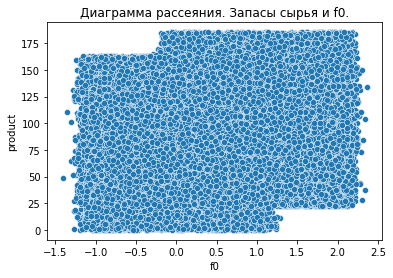

In [149]:
sns.scatterplot(data=geo_data0, y='product', x='f0')
plt.title('Диаграмма рассеяния. Запасы сырья и f0.')
plt.show()

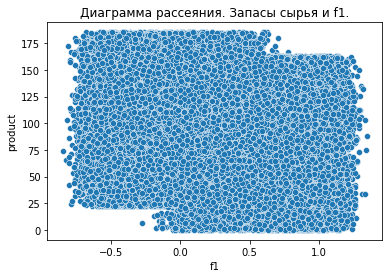

In [150]:
sns.scatterplot(data=geo_data0, y='product', x='f1')
plt.title('Диаграмма рассеяния. Запасы сырья и f1.')
plt.show()

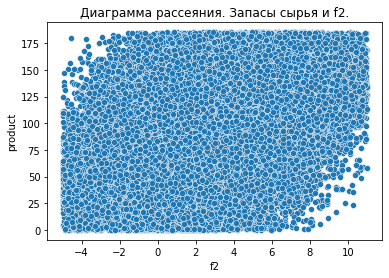

In [151]:
sns.scatterplot(data=geo_data0, y='product', x='f2')
plt.title('Диаграмма рассеяния. Запасы сырья и f2.')
plt.show()

Диаграммы показывают отсутствие линейной связи между входными и целевым признаком.

### Корреляционный анализ geo_data1.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


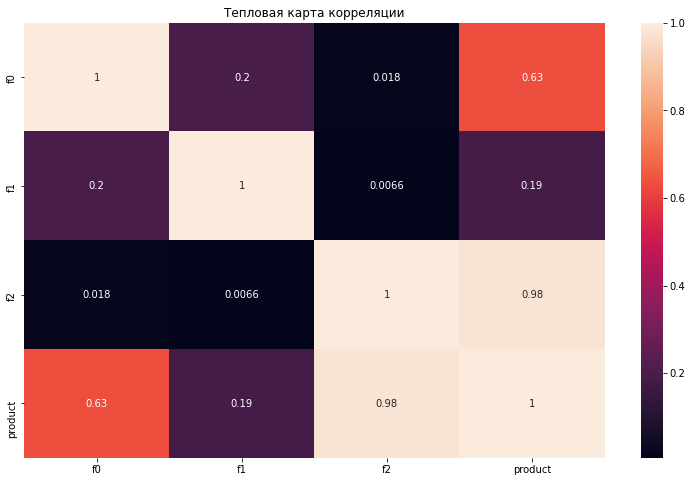

In [152]:
plt.figure(figsize=(13, 8))
sns.heatmap(geo_data1.drop('id',axis=1).phik_matrix(), annot=True) 
plt.title("Тепловая карта корреляции")
plt.show()

Во втором регионе у целевого признака наиболее выраженная корреляция с "f2" - 0.98, далее 0.63 с "f0" и совсем низкая - 0.19 с "f1".

Так же построим диаграммы рассеяния для более наглядной демонстрации зависимости.

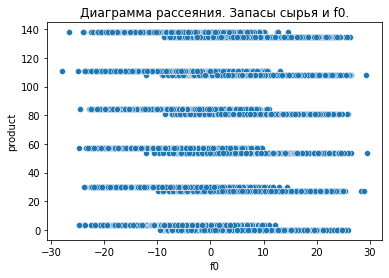

In [153]:
sns.scatterplot(data=geo_data1, y='product', x='f0')
plt.title('Диаграмма рассеяния. Запасы сырья и f0.')
plt.show()

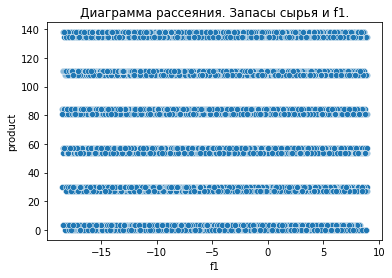

In [154]:
sns.scatterplot(data=geo_data1, y='product', x='f1')
plt.title('Диаграмма рассеяния. Запасы сырья и f1.')
plt.show()

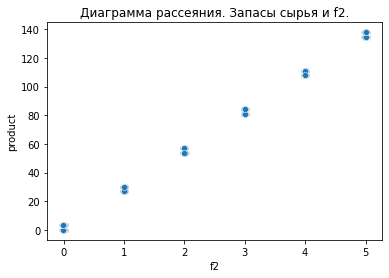

In [155]:
sns.scatterplot(data=geo_data1, y='product', x='f2')
plt.title('Диаграмма рассеяния. Запасы сырья и f2.')
plt.show()

Диаграммы показывают отсутсвие линейной связи между целевым признаком с "f0" и "ff1", при этом наблюдается ярковыраженная линейная зависимость с "f2".

### Корреляционный анализ geo_data2.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


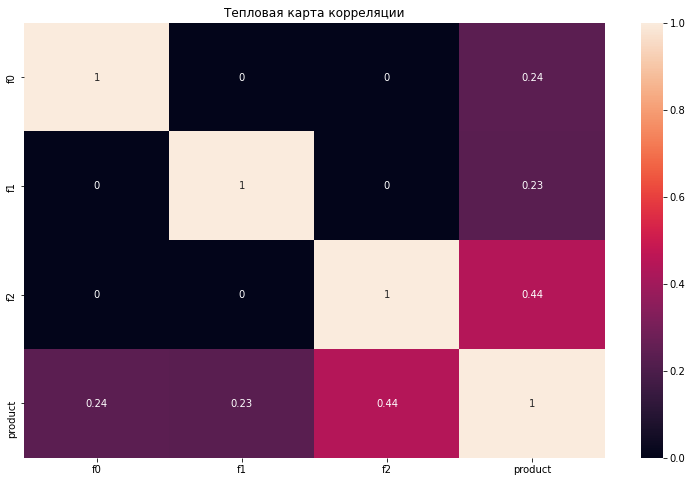

In [156]:
plt.figure(figsize=(13, 8))
sns.heatmap(geo_data2.drop('id',axis=1).phik_matrix(), annot=True) 
plt.title("Тепловая карта корреляции")
plt.show()

В третьем регионе наиболее выраженная связь у целевого признака с "f2" - 0.44. С "f1" и "f0" корреляция слабая - 0.23 и 0.24 соотвественно.

Построим диаграммы рассеяния для более наглядной демонстрации зависимости.

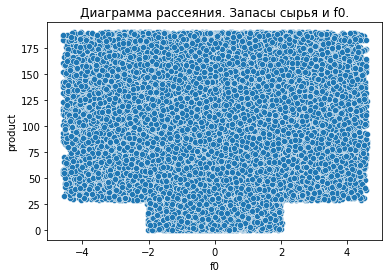

In [157]:
sns.scatterplot(data=geo_data2, y='product', x='f0')
plt.title('Диаграмма рассеяния. Запасы сырья и f0.')
plt.show()

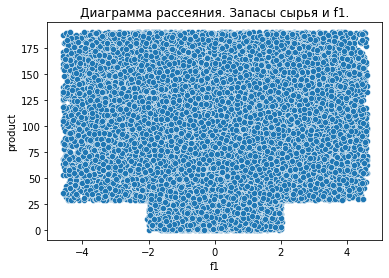

In [158]:
sns.scatterplot(data=geo_data2, y='product', x='f1')
plt.title('Диаграмма рассеяния. Запасы сырья и f1.')
plt.show()

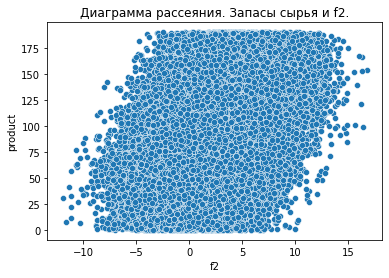

In [159]:
sns.scatterplot(data=geo_data2, y='product', x='f2')
plt.title('Диаграмма рассеяния. Запасы сырья и f2.')
plt.show()

Диаграммы показывают отсутсвие линейной связи у целевого признака с "f0" и "f1", так же наблюдается совсем слабовыраженная линейная зависимость с "f2".

### Вывод по корреляционному анализу.<br>
1. Первый регион: <br>
1) Наиболее выраженная корреляция у целевого признака "product" с "f2" - 0.47. С "f1" и "f0" корреляция низкая - 0.25 и 0.21 соотвественно. Так же наблюдается зависимость между "f1" и "f0" - 0.76.<br>
2) Диаграммы показывают отсутствие линейной связи между входными и целевым признаком.<br>
2. Второй регион:<br>
1) У целевого признака наиболее выраженная корреляция с "f2" - 0.98, далее 0.63 с "f0" и совсем низкая - 0.19 с "f1".<br>
2) Диаграммы показывают отсутсвие линейной связи между целевым признаком с "f0" и "ff1", при этом наблюдается ярковыраженная линейная зависимость с "f2".<br>
3. Третий регион:<br>
1) Наиболее выраженная связь у целевого признака с "f2" - 0.44. С "f1" и "f0" корреляция слабая - 0.23 и 0.24 соотвественно.<br>
2) Диаграммы показывают отсутсвие линейной связи у целевого признака с "f0" и "f1", так же наблюдается совсем слабовыраженная линейная зависимость с "f2".<br>

## Обучение и проверка моделей для каждого региона.

Создадим функцию, которая будет:
1. Разделять данные на обучающие и валидационные выборки.
2. Обрабатывать численные значения.
3. Обучать модель линейной регрессии.
4. Делать предсказания на валидационной выборке.
5. Считать средний запас предсказанного сырья.
6. Вычислять RMSE модели.
7. Объединять валидационные и предсказаныые значения.
8. Так же добавим dummy-модел. Она позволит оценить успешность моделей.

In [160]:
def pipe(data, region):
    X = data.drop(['product','id'],axis=1)
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,
                                                              random_state=RANDOM_STATE)
    num_columns = ['f0','f1','f2']
    data_preprocessor = ColumnTransformer([
    
     ('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
    )

    # создаём итоговый пайплайн: подготовка данных и модель
    pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
    ])
    pipe_final.fit(X_train,y_train)
    
    y_pred = pipe_final.predict(X_valid)
    
    dummy_model = DummyRegressor(strategy='mean')
    dummy_model.fit(X_train, y_train)
    y_pred_dummy = dummy_model.predict(X_valid)
    
    rmse_dummy = mean_squared_error(y_valid, y_pred_dummy, squared=False)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    
    print(f'{region} регион:')
    print()
    print("Средний запас предсказанного сырья:", y_pred.mean().round(6))
    print("RMSE на валидационной выборке:", rmse )
    print()
    print("Для dummy-модели:")
    print("Средний запас предсказанного сырья:", y_pred_dummy.mean().round(6))
    print("RMSE на валидационной выборке:", rmse_dummy)
    
    y_valid = pd.Series(y_valid, name='y_valid').reset_index(drop=True)
    
    y_pred = pd.Series(y_pred, name='y_pred').reset_index(drop=True)
    
    valid_data = pd.concat([y_valid, y_pred], axis=1)
    
    return valid_data

Выведем полученные значения для каждого региона. Сохраним таблицу с предсказанными и фактическими значениями в переменную и проверим на наличие пропусков и дубликатов.

In [161]:
valid_data0 = pipe(geo_data0, 'Первый')

Первый регион:

Средний запас предсказанного сырья: 93.019638
RMSE на валидационной выборке: 37.905505442079345

Для dummy-модели:
Средний запас предсказанного сырья: 92.82418
RMSE на валидационной выборке: 44.464314548282005


In [162]:
valid_data0.isna().sum()

y_valid    0
y_pred     0
dtype: int64

In [163]:
valid_data0.duplicated().sum()

0

In [164]:
valid_data1 = pipe(geo_data1, 'Второй')

Второй регион:

Средний запас предсказанного сырья: 68.946299
RMSE на валидационной выборке: 0.8888117301070085

Для dummy-модели:
Средний запас предсказанного сырья: 68.76356
RMSE на валидационной выборке: 45.93756199156136


In [165]:
valid_data1.isna().sum()

y_valid    0
y_pred     0
dtype: int64

In [166]:
valid_data0.duplicated().sum()

0

In [167]:
valid_data2 = pipe(geo_data2, 'Третий')

Третий регион:

Средний запас предсказанного сырья: 94.800335
RMSE на валидационной выборке: 40.09717367634891

Для dummy-модели:
Средний запас предсказанного сырья: 94.7875
RMSE на валидационной выборке: 44.74468621944356


In [168]:
valid_data2.isna().sum()

y_valid    0
y_pred     0
dtype: int64

In [169]:
valid_data2.duplicated().sum()

0

### Вывод по обучению моделей.
1. Лучшие показатели у модели во втором регионе RMSE - 0.8888117301070085 ,у dummy-модели - 45.93756199156136. Это ожидаемый результат, т.к. только во втором регионе была выраженная линейная связь между входным и целевым признаком.
2. Показатели моделей в первом и третьем регионах не сильно лучше чем у dummy-модели. Первый регион: RMSE модели - 37.905505442079345, RMSE dummy-модели - 44.464314548282005. Третий регион: RMSE модели - 40.09717367634891, RMSE dummy-модели - 44.74468621944356.

## Подготовка к расчёту прибыли

Сейчас сохраним все ключевые значения для рассчета прибыли в переменные. Далее расчитаем минимальный объем для безубыточной разработки и сравним полученный объём сырья со средним запасом в каждом регионе. 

In [221]:
# бюджет на разработку в регионе 10млрд.
BUDGET = 10**10

In [222]:
# кол-во разрабатываемых скважин в регионе
POINTS_PER_BUDGET = 200

In [223]:
# стоимость 1000 барелей
COST = 450000

In [224]:
# стоимсоть разработки одной скважины
COST_PER_BUDGET = BUDGET / POINTS_PER_BUDGET

In [225]:
PRODUCT = 0

In [226]:
# формула прибыли
PROFIT = PRODUCT*COST - COST_PER_BUDGET

In [227]:
# расчет 
PRODUCT = COST_PER_BUDGET / COST
print("Минимальное объём сырья для безубыточной разработки новой скважины:",PRODUCT)

Минимальное объём сырья для безубыточной разработки новой скважины: 111.11111111111111


Создадим функцию для подсчета среднего запаса сырья в каждом регионе.

In [179]:
def product_mean(y_valid,region):
    print(f"Средний запас сырья в {region} регионе:", y_valid.mean().round(6))

In [180]:
product_mean(valid_data0['y_valid'], 'первом')

Средний запас сырья в первом регионе: 92.503112


In [181]:
product_mean(valid_data1['y_valid'], 'втором')

Средний запас сырья в втором регионе: 68.938219


In [183]:
product_mean(valid_data2['y_valid'], 'третьем')

Средний запас сырья в третьем регионе: 94.598667


### Вывод по подготовке к расчету прибыли.
1. Минимальное объём сырья для безубыточной разработки новой скважины: 111.(1).<br>
2. В каждом регионе средний запас сырья меньше, чем необходимо для безубыточной разработки:<br>
1) Средний запас сырья в первом регионе: 92.503112 <br>
2) Средний запас сырья в втором регионе: 68.938219<br>
3) Средний запас сырья в третьем регионе: 94.598667<br>

## Функция для  расчёта прибыли. 

Напишшем функцию для подсчета прибыли, которая будет сортировать и отбирать 200 лучших скважин. Далее расчитаем прибыль для полученного объема сырья.

In [217]:
def profit(data, count=200):
    selected = data.sort_values(by = 'y_pred',ascending=False)['y_valid'][:count].sum()
    profit = cost*selected - budget
    return profit    

In [218]:
print("Суммарная выручка в первом регионе:",profit(valid_data0))

Суммарная выручка в первом регионе: 3376897416.884199


In [219]:
print("Суммарная выручка во втором регионе:",profit(valid_data1))

Суммарная выручка во втором регионе: 2415086696.681511


In [220]:
print("Суммарная выручка в третьем регионе:",profit(valid_data2))

Суммарная выручка в третьем регионе: 2643325058.82889


### Вывод по созданию функции для расчёта прибыли.
1. Суммарная выручка в первом регионе: 3376897416.884199
2. Суммарная выручка во втором регионе: 2415086696.681511
3. Суммарная выручка в третьем регионе: 2643325058.82889
4. Самая большая суммарная выручка из 200 лучших скважин в перовм регионе, на втором месте третий регион и на третьем второй.

## Расчет рисков и прибыли для каждого региона.

Далее создадим функцию, которая:
1. Применяя технику Bootstrap с 1000 выборок найдет распределение прибыли для каждого региона.
2. Среднюю прибыль.
3. 95%-й доверительный интервал.
4. Риск убытков.
5. Построит гистограммы расспределения прибыли.

In [213]:
def quntile(data,region):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        data_subsample = data.sample(n=500, replace=True, random_state=state)
        revenue_value = revenue(data_subsample)
        values.append(revenue_value)

    values = pd.Series(values)
    
    
    mean = values.mean()
    risk_of_loss = values[values<0].count() / values.count() * 100 
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    print(f"{region}.")
    print("Средняя выручка:", mean)
    print(f"Риск убытков:{risk_of_loss:.1f}%")
    print(f"95%-й доверительный интервал: от {lower} до {upper}.")
    values.hist()
    plt.title('Гистограмма возможной выручки.')
    plt.xlabel('Прибыль')
    plt.ylabel('Частота')

Первый регион.
Средняя выручка: 411028993.621491
Риск убытков:6.5%
95%-й доверительный интервал: от -123030252.16544676 до 925006027.6382338.


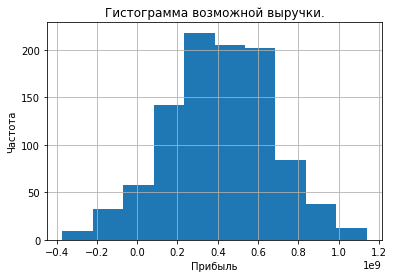

In [214]:
quntile(valid_data0,'Первый регион')

Второй регион.
Средняя выручка: 462105733.1291018
Риск убытков:0.9%
95%-й доверительный интервал: от 71067324.48485813 до 838748550.1893427.


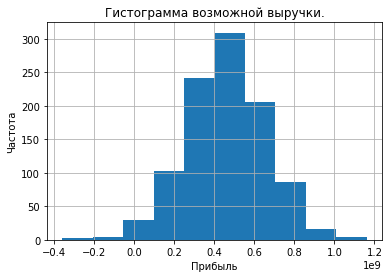

In [215]:
quntile(valid_data1,'Второй регион')

Третий регион.
Средняя выручка: 343943331.4596185
Риск убытков:9.3%
95%-й доверительный интервал: от -179292101.44938448 до 892779407.0718838.


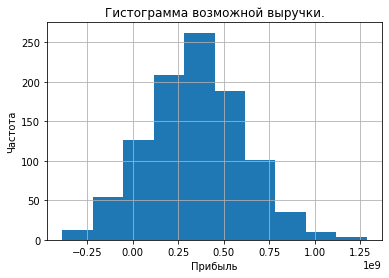

In [216]:
quntile(valid_data2,'Третий регион')

### Вывод по расчету рисков и прибыли для каждого региона. 
1. Риск убытков в первом регионе -6.5%, во втором - 0.9% и в третьем - 9.3%.
2. Наибольшая средняя прибыль во втором регионе - 462105733.1291018, далее идет первый регион - 411028993.621491, на последнем месте третий регион - 343943331.4596185.
3. Такое же расспределение мы наблюдаем и у 95% доверительного интервала. Первый регион от -123030252.16544676 до 925006027.6382338. Второй регион от 71067324.48485813 до 838748550.1893427. Третий регион от -179292101.44938448 до 892779407.0718838.
4. Наилучшим регионом для разработки будет второй. Именно у него самая высокая средняя прибыль, самый низкий риск убытков - 0.9% и 95% доверительный интервал полностью безубыточный.

# Общий вывод.
1. Вывод по загрузке и подготовке данных:<br>
1) Все три таблицы сохранили в переменные.<br>
2) Формат данных соотвествует истеному.<br>
3) Пропусков и дубликатов нет.<br>
<br>
2. Исследовательский анализ:<br>
Выводы по анализу первого региона.<br>
1) Расспределение "product" близко к нормальному.<br>
2) "f2" стремится к нормальному расспределению.<br>
3) "fo" и "f1" не имеют нормального расспределения.<br>
2) Значения "product" , в основном, лежат в диапозоне от 56.5 до 128.6 тыс.барелей. Боксплот показывает отсутствие выбросов.<br>
3) Большая часть значений "f0" от -0.07 до 1.01. Выбросов нет.<br>
4) В основном, "f1" в диапозоне от -0.2 до 0.7. Выбросы отсутствуют.<br>
5) Значения "f2" по большей чатси, от 0.288 до 4.7. На боксплоте видим выбросы в верхней и нежний частях. Нам не известно что именно из себя представляют входные признаки, но т.к. нам нужно будет использовать модель линейной регрессии, выбросы придется убрать, они плохо повлияют на обучение модели. Удалили 1353 скважины.<br>
Вывод по анализу второго региона.<br>
1) Расспределение данных во втором регионе. Только у "f1" расспределение близко к нормальному, у остальных данных нет.<br>
2) Значения "product" , в основном, лежат в диапозоне от 26.95 до 107.8 тыс.барелей. Боксплот показывает отсутствие выбросов.<br>
3) Большая часть значений "f0" от -6.3 до 8.6. На боксплоте обнаружили выброс. Убрали его.<br>
4) В основном, "f1" в диапозоне от -8.26 до -1.33. Так же на боксплоте обнаружили выбросы. Избавились от них.<br>
5) Значения "f2" по большей чатси, от 1 до 3.99. Выбросов нет.<br>
6) Всего убрали 710 скважин.<br>
Вывод по анализу третьего региона.<br>
1) Расспределение "product" в третьем регионе похоже на нормальное, остальные признаки так же стремятся к нормальному расспределению.<br>
2) Значения "product" , в основном, лежат в диапозоне от 59.45 до 130.6 тыс.барелей. Боксплот показывает отсутствие выбросов.<br>
3) Большая часть значений "f0" от -1.15 до 1.14. На боксплоте обнаружили выбросы. Убрали их.<br>
4) В основном, "f1" в диапозоне от -7.06 до 1.16. Так же на боксплоте обнаружили выбросы. Избавились от них.<br>
5) Значения "f2" по большей чатси, от 0.13 до 4.85. Так же на боксплоте обнаружили выбросы. Убрали их.<br>
6) Удалили 1547 скважин.<br>
Вывод по исследовательскому анализу.<br>
1) В таблицах всех регионов были обнаружены выбросы, пришлось их удалить. Они плохо повлияют на обучение модели линейной регрессии.<br>
2) Даныые отличаются от региона к региону, поэтому создадим отдельные модели для каждого.<br>
<br>
3. Вывод по корреляционному анализу.<br>
Первый регион: <br>
1) Наиболее выраженная корреляция у целевого признака "product" с "f2" - 0.47. С "f1" и "f0" корреляция низкая - 0.25 и 0.21 соотвественно. Так же наблюдается зависимость между "f1" и "f0" - 0.76.<br>
2) Диаграммы показывают отсутствие линейной связи между входными и целевым признаком.<br>
Второй регион:<br>
1) У целевого признака наиболее выраженная корреляция с "f2" - 0.98, далее 0.63 с "f0" и совсем низкая - 0.19 с "f1".<br>
2) Диаграммы показывают отсутсвие линейной связи между целевым признаком с "f0" и "ff1", при этом наблюдается ярковыраженная линейная зависимость с "f2".<br>
Третий регион:<br>
1) Наиболее выраженная связь у целевого признака с "f2" - 0.44. С "f1" и "f0" корреляция слабая - 0.23 и 0.24 соотвественно.<br>
2) Диаграммы показывают отсутсвие линейной связи у целевого признака с "f0" и "f1", так же наблюдается совсем слабовыраженная линейная зависимость с "f2".<br>
<br>
4. Вывод по обучению моделей.<br>
1) Лучшие показатели у модели во втором регионе RMSE - 0.8888117301070085 ,у dummy-модели - 45.93756199156136. Это ожидаемый результат, т.к. только во втором регионе была выраженная линейная связь между входным и целевым признаком.<br>
2) Показатели моделей в первом и третьем регионах не сильно лучше чем у dummy-модели. Первый регион: RMSE модели - 37.905505442079345, RMSE dummy-модели - 44.464314548282005. Третий регион: RMSE модели - 40.09717367634891, RMSE dummy-модели - 44.74468621944356.<br>
<br>
5. Вывод по подготовке к расчету прибыли.<br>
1) Минимальное объём сырья для безубыточной разработки новой скважины: 111.(1).<br>
2) В каждом регионе средний запас сырья меньше, чем необходимо для безубыточной разработки:<br>
1) Средний запас сырья в первом регионе: 92.503112 <br>
2) Средний запас сырья в втором регионе: 68.938219<br>
3) Средний запас сырья в третьем регионе: 94.598667<br>
<br>
6. Вывод по созданию функции для расчёта прибыли.<br>
1) Суммарная выручка в первом регионе: 3376897416.884199<br>
2) Суммарная выручка во втором регионе: 2415086696.681511<br>
3) Суммарная выручка в третьем регионе: 2643325058.82889<br>
4) Самая большая суммарная выручка из 200 лучших скважин в перовм регионе, на втором месте третий регион и на третьем второй.<br>
<br>
7. Вывод по расчету рисков и прибыли для каждого региона.<br>
1) Риск убытков в первом регионе -6.5%, во втором - 0.9% и в третьем - 9.3%.<br>
2) Наибольшая средняя прибыль во втором регионе - 462105733.1291018, далее идет первый регион - 411028993.621491, на последнем месте третий регион - 343943331.4596185.<br>
3) Такое же расспределение мы наблюдаем и у 95% доверительного интервала. Первый регион от -123030252.16544676 до 925006027.6382338. Второй регион от 71067324.48485813 до 838748550.1893427. Третий регион от -179292101.44938448 до 892779407.0718838.<br>
4) Наилучшим регионом для разработки будет второй. Именно у него самая высокая средняя прибыль, самый низкий риск убытков - 0.9% и 95% доверительный интервал полностью безубыточный.